In [37]:
# Load all Libraries 

%matplotlib inline

import IPython.display

from numpy import * 

import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import os
import time

from IPython import embed
import ipdb

import theano
import theano.tensor as Th
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers import ElemwiseSumLayer,LSTMLayer,ReshapeLayer,ElemwiseMergeLayer,LSTMLayer
from lasagne.layers import SliceLayer, get_output, get_all_params
from lasagne.updates import adam
import downhill

eps = finfo( float32).eps;

In [2]:
# Load a TIMIT data set
def tset( mf = None, ff = None, dr = None):
    # Where the files are
    p = '/Users/avinana/Paris Independent Study/timit-wav/train/';

    # Pick a speaker directory
    if dr is None:
        dr = random.randint( 1, 8)
    p += 'dr%d/' % dr

    # Get two random speakers
    if mf is None:
        mf = [name for name in os.listdir( p) if name[0] == 'm']
        mf = random.choice( mf)
    if ff is None:
        ff = [name for name in os.listdir( p) if name[0] == 'f']
        ff = random.choice( ff)
    print ('dr%d/' % dr), mf, ff

    # Load all the wav files
    ms = [wavfile.read(p+mf+'/'+n)[1] for n in os.listdir( p+mf) if 'wav' in n]
    fs = [wavfile.read(p+ff+'/'+n)[1] for n in os.listdir( p+ff) if 'wav' in n]

    # Find suitable test file pair
    l1 = map( lambda x : x.shape[0], ms)
    l2 = map( lambda x : x.shape[0], fs)
    d = array( [[abs(t1-t2) for t1 in l1] for t2 in l2])
    i = argmin( d)
    l = max( [l1[i%10], l2[i/10]])
    ts = [pad( ms[i%10], (0,l-l1[i%10]), 'constant'), pad( fs[i/10], (0,l-l2[i/10]), 'constant')]

    # Get training data
    ms.pop( i%10)
    fs.pop( i/10)
    tr = [concatenate(ms), concatenate(fs)]

    return map( lambda x : (x-mean(x))/std(x), ts), map( lambda x : (x-mean(x))/std(x), tr)

In [3]:
# Load data (make it a function, with the choice of TIMIT and mock data)

def sound_set( tp):
    import scipy.io.wavfile as wavfile
#     import paris.speech

    # Two sinusoids signal
    if tp == 1:
        l = 8*1024
        sr = 8000
        def clip0( x):
            return x * (x>0)
        z1 = clip0( sin( 3*linspace( 0, 2*pi, l))) * sin( 1099*linspace( 0, 2*pi, l))
        z2 = clip0( sin( 2*linspace( 0, 2*pi, l))) * sin( 3222*linspace( 0, 2*pi, l))
        z3 = clip0( sin( 5*linspace( 0, 2*pi, l))) * sin( 1099*linspace( 0, 2*pi, l))
        z4 = clip0( sin( 3*linspace( 0, 2*pi, l))) * sin( 3222*linspace( 0, 2*pi, l))

        z1 = hstack( (zeros(l/8),z1))
        z2 = hstack( (zeros(l/8),z2))
        z3 = hstack( (zeros(l/8),z3))
        z4 = hstack( (zeros(l/8),z4))

    
    # TIMIT male/female set
    elif tp == 2:
        #ts,tr = tset( 'fpad0', 'mbma1', 6)
        ts,tr = tset()
        sr = 16000

        tr[0] = tr[0][:min(tr[0].shape[0],tr[1].shape[0])]
        tr[1] = tr[1][:min(tr[0].shape[0],tr[1].shape[0])]

        z1 = tr[1] / std( tr[1])
        z2 = tr[0] / std( tr[0])
        z3 = ts[1] / std( ts[1])
        z4 = ts[0] / std( ts[0])

    # Pad them
    sz = 1024

    def zp( x):
        return hstack( (zeros(sz),x[:int(sz*floor(x.shape[0]/sz))],zeros(sz)))

    tr1 = zp( z1[:int(sz*floor(z1.shape[0]/sz))])
    tr2 = zp( z2[:int(sz*floor(z2.shape[0]/sz))])
    ts1 = zp( z3[:int(sz*floor(z3.shape[0]/sz))])
    ts2 = zp( z4[:int(sz*floor(z4.shape[0]/sz))])

    # Show me
    #soundsc( ts1+ts2, sr)

    return tr1,tr2,ts1,ts2

In [4]:
########################################
# Class to extract sound features (STFT)
# Input : sz : Size
#         hp : hop size 
#         wn : window function 
########################################

class sound_feats:

    # Initializer
    def __init__(self, sz, hp, wn):
        import scipy.fftpack

        self.sz = sz
        self.hp = hp
        self.wn = wn

        # Forward transform definition
        self.F = scipy.fftpack.fft( identity( self.sz))

        # Inverse transform with a window
        self.iF = conj( self.wn * self.F.T)

    # Modulator definition
    def md( self, x):
        return abs( x)+eps

    # Buffer with overlap
    def buffer( self, s):
        return array( [s[i:i+self.sz] for i in arange( 0, len(s)-self.sz+1, self.hp)]).T

    # Define overlap add matrix
    def oam( self, n):
        import scipy.sparse
        ii = array( [i*self.hp+arange( self.sz) for i in arange( n)]).flatten()
        jj = array( [i*self.sz+arange( self.sz) for i in arange( n)]).flatten()
        return scipy.sparse.coo_matrix( (ones( len( ii)), (ii,jj)) ).tocsr()

    # Front end
    def fe( self, s):
        C = self.F.dot( self.wn*self.buffer( s))[:self.sz/2+1,:]
        M = self.md( C)
        P = C / M
        return (M,P)

    # Inverse transform
    def ife( self, M, P):
        oa = self.oam( M.shape[1])
        f = vstack( (M*P,conj(M*P)[-2:0:-1,:]))
        return oa.dot( reshape( real( self.iF.dot( f)), (-1,1), order='F')).flatten()

In [5]:
##################
# Blind Source seperation evaluation
##################
from numpy import *

# SDR, SIR, SAR estimation
def bss_eval( sep, i, sources):
    # Current target
    target = sources[i]
    
    # Target contribution
    s_target = target * dot( target, sep.T) / dot( target, target.T)

    # Interference contribution
    pse = dot( dot( sources, sep.T),linalg.inv( dot( sources, sources.T))).T.dot( sources)
    e_interf = pse - s_target
    
    # Artifact contribution
    e_artif= sep - pse;
    
    # Interference + artifacts contribution
    e_total = e_interf + e_artif;
    
    # Computation of the log energy ratios
    sdr = 10*log10( sum( s_target**2) / sum( e_total**2));
    sir = 10*log10( sum( s_target**2) / sum( e_interf**2));
    sar = 10*log10( sum( (s_target + e_interf)**2) / sum( e_artif**2));
    
    # Done!
    return (sdr, sir, sar)

In [6]:
########################
# Define a training loop 
########################

def downhill_train( opt, train, hh, ep, pl):
    cst = []
    st = time.time()
    lt = st
    try:
        for tm,_ in opt.iterate( train, learning_rate=hh, max_updates=ep, patience=ep, min_improvement=0):
            cst.append( tm['loss'])
            if time.time() - lt > 4 :
                nt = time.time()
                epc = len( cst)
                plt.clf()
                plt.plot(cst)
    #             plt.semilogy( cst)
                plt.title( 'Cost: %.1e  Speed: %.2f ep/s  Time: %.1f/%.1f' %(cst[-1], epc/(nt-st), nt-st, ep/(epc/(nt-st))) )
                plt.ylabel( 'Cost')
                IPython.display.clear_output(wait = True)
                plt.show()
                lt = time.time()
    except KeyboardInterrupt:
        pass
    return cst

In [7]:
#########################################################
# Neural net : Define the lasagne seperation neural net

#########################################################
# %debug
def psoftplus( x, p = 1.):
    return Th.switch( x < -30./p, 0., Th.switch( x > 30./p, x, Th.log1p( Th.exp( p*x))/p))


# Get a Lasagne layer output
def nget( x, s, y):
    return theano.function( [s], squeeze( get_output( x, deterministic=True)))( y)

# Learn models using a Lasagne network
def lasagne_models( M, P, FE, z, K = 20, hh = .0001, ep = 5000, d = 0, wsp = 0.0001, plt = True):
    
    # Copy key variables to GPU
    _M = Th.matrix( '_M')

    # Input and forward transform
    I = InputLayer( shape=M.T.shape, input_var=_M)

    # First layer is the transform to a non-negative subspace
    H0  = DenseLayer( I, num_units=K, nonlinearity=lambda x: psoftplus( x, 3.), b=None)

    # Optional dropout
    H = DropoutLayer( H0, d)

    # Compute source modulator
    R  = DenseLayer( H, num_units=M.T.shape[1], nonlinearity=lambda x: psoftplus( x, 3.), b=None)

    # Cost function
    cost = (_M*(Th.log(_M+eps) - Th.log( get_output( R)+eps)) - _M + get_output( R)).mean() \
       + wsp*Th.mean( abs( R.W))

    # Train it using Lasagne
    opt = downhill.build( 'rprop', loss=cost, inputs=[_M], params=get_all_params( R))
    train = downhill.Dataset( M.T.astype(float32), batch_size=0)
    er = downhill_train( opt, train, hh, ep, None)[-1]
    #er = train_loop( opt, train, hh, ep, None)[-1]
    # Get approximation
    _r = nget( R, _M, M.T.astype( float32)).T
    _h = nget( H, _M, M.T.astype( float32)).T
    o = FE.ife( _r, P)
    sxr = bss_eval( o, 0, array([z]))

    return R ,sxr

In [8]:
def lasagne_separate2( M, P, FE, W1, W2, z1, z2, hh = .0001, ep = 5000, d = 0, wsp =.0001, plt = True):

    # Gt dictionary shapes
    K = [W1.shape[0],W2.shape[0]]

    # GPU cached data
    _M = theano.shared( M.T.astype( float32))
    dum = Th.vector( 'dum')

    # We have weights to discover
    H = theano.shared( random.rand( M.T.shape[0],K[0]+K[1]).astype( float32))
    fI = InputLayer( shape=(M.T.shape[0],K[0]+K[1]), input_var=H)

    # Split in two pathways
    fW1 = SliceLayer( fI, indices=slice(0,K[0]), axis=1)
    fW2 = SliceLayer( fI, indices=slice(K[0],K[0]+K[1]), axis=1)

    # Dropout?
    dfW1 = DropoutLayer( fW1, d)
    dfW2 = DropoutLayer( fW2, d)

    # Compute source modulators using previously learned dictionaries
    R1  = DenseLayer( dfW1, num_units=M.shape[0], W=W1.astype( float32),
      nonlinearity=lambda x: psoftplus( x, 3.), b=None)
    R2  = DenseLayer( dfW2, num_units=M.shape[0], W=W2.astype( float32),
      nonlinearity=lambda x: psoftplus( x, 3.), b=None)

    # Add the two approximations
    R = ElemwiseSumLayer( [R1, R2])

    # Cost function
    cost = (_M*(Th.log(_M+eps) - Th.log( get_output( R)+eps)) - _M + get_output( R)).mean() \
       + wsp*Th.mean( H) # + 0*Th.mean( dum)

    # Train it using Lasagne
    opt = downhill.build( 'rprop', loss=cost, inputs=[dum], params=[H])
    train = downhill.Dataset( _M, batch_size=0)
    er = downhill_train( opt, train, hh, ep, None)[-1]

    # Get outputs
    _r  = nget( R,  dum, array( [0]).astype(float32)) + eps
    _r1 = nget( R1, dum, array( [0]).astype(float32))
    _r2 = nget( R2, dum, array( [0]).astype(float32))
    o1 = FE.ife( _r1 * (M/_r), P)
    o2 = FE.ife( _r2 * (M/_r), P)
    sxr = bss_eval( o1, 0, vstack( (z1,z2))) + bss_eval( o2, 1, vstack( (z1,z2)))

    return o1,o2,(array(sxr[:3]) + array(sxr[3:]))/2.

In [9]:
def lasagne_separate( M, P, FE, W1, W2, z1, z2, hh = .0001, ep = 5000, d = 0, wsp =.0001, plt = True):

    # Gt dictionary shapes
    K = [W1.shape[0],W2.shape[0]]

    # GPU cached data
    _M = theano.shared( M.astype( float32))

    # Input is the learned dictionary set
    lW = hstack( (W1.T,W2.T)).astype( float32)
    _lW  = Th.matrix( '_lW');
    fI = InputLayer( shape=lW.shape, input_var=_lW)

    # Split in two paths
    fW1 = SliceLayer( fI, indices=slice(0,K[0]), axis=1)
    fW2 = SliceLayer( fI, indices=slice(K[0],K[0]+K[1]), axis=1)

    # Dropout?
    dfW1 = DropoutLayer( fW1, d)
    dfW2 = DropoutLayer( fW2, d)

    # Compute source modulators
    R1  = DenseLayer( dfW1, num_units=M.shape[1], nonlinearity=lambda x: psoftplus( x, 3.), b=None)
    R2  = DenseLayer( dfW2, num_units=M.shape[1], nonlinearity=lambda x: psoftplus( x, 3.), b=None)

    # Bring to standard orientation
    R = ElemwiseSumLayer( [R1, R2])

    # Cost function
    cost = (_M*(Th.log(_M+eps) - Th.log( get_output( R)+eps)) - _M + get_output( R)).mean() \
       + wsp*(Th.mean( abs( R1.W))+Th.mean( abs( R2.W)))

    # Train it using Lasagne
    opt = downhill.build( 'rprop', loss=cost, inputs=[_lW], params=get_all_params( R))
    train = downhill.Dataset( lW, batch_size=0)
    er = downhill_train( opt, train, hh, ep, None)[-1]

    # Get outputs
    _r  = nget( R,  _lW, lW) + eps
    _r1 = nget( R1, _lW, lW)
    _r2 = nget( R2, _lW, lW)
    o1 = FE.ife( _r1 * (M/_r), P)
    o2 = FE.ife( _r2 * (M/_r), P)
    sxr = bss_eval( o1, 0, vstack( (z1,z2))) + bss_eval( o2, 1, vstack( (z1,z2)))

    return o1,o2,(array(sxr[:3]) + array(sxr[3:]))/2.

In [10]:
# Load sound set
# %debug

random.seed( 0)
Z = sound_set(1)

sz = 1024
hp = 256
# Front-end details
if hp is None:
    hp = sz/4
wn = reshape( hanning(sz+1)[:-1], (sz,1))**.5
FE = sound_feats(sz,hp,wn)



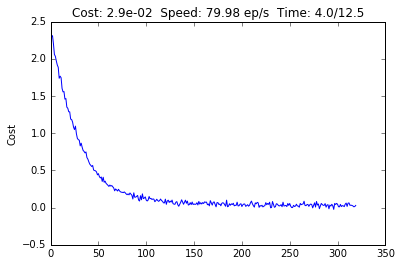

In [11]:
M1,P1 = FE.fe( Z[0])
n1,c1 = lasagne_models( M1, P1, FE, Z[0],20, .001, 1000, 0.25, .0001, False)

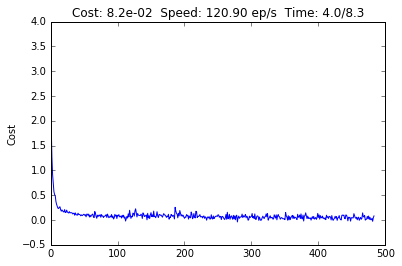

In [12]:
M2,P2 = FE.fe( Z[1])
n2,c2 = lasagne_models( M2, P2, FE, Z[1], 20, .01, 1000, 0.25, .0001, False)

In [ ]:
# 

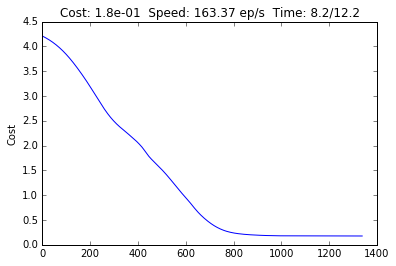

In [25]:
M,P = FE.fe( Z[2]+Z[3])
o1,o2,sxr = lasagne_separate( M, P, FE, n1.W.get_value(), n2.W.get_value(),Z[2], Z[3], .0001, 2000, 0, 0.01, False)

In [38]:
# from lasagne.layers import LSTMLayer

M,P = FE.fe( Z[2]+Z[3])
W1 = n1.W.get_value()
W2 = n2.W.get_value()
K = [W1.shape[0], W2.shape[0]]

z1 = Z[2]
z2 = Z[3]
wsp=0.01
hh = 0.0001
ep = 100
d = 0
# Gt dictionary shapes

# GPU cached data
_M = theano.shared(M.astype(float32))

# Input is the learned dictionary set
lW = hstack((W1.T, W2.T)).astype(float32)
_lW = Th.matrix('_lW');
fI = InputLayer(shape=lW.shape, input_var=_lW)

# Split in two paths
fW1 = SliceLayer(fI, indices=slice(0, K[0]), axis=1)
fW2 = SliceLayer(fI, indices=slice(K[0], K[0] + K[1]), axis=1)

############ LSTM Layer #####################

# Reshape input for LSTM (Single sequence)
fW1_reshape = ReshapeLayer(fW1,(1,[0],[1]))
fW2_reshape = ReshapeLayer(fW2,(1,[0],[1]))

# LSTM Layer with 

N_HIDDEN = M.shape[1]
rec1 = LSTMLayer(fW1_reshape, N_HIDDEN)
rec2 = LSTMLayer(fW2_reshape, N_HIDDEN)

lstm_out1 = ReshapeLayer(rec1,([1],[2]))
lstm_out2 = ReshapeLayer(rec2,([1],[2]))
#############################################

############ Train for weights(Activations in NMF) Layer #####################

# Dropout?
dfW1 = DropoutLayer(fW1, d)
dfW2 = DropoutLayer(fW2, d)


# Compute source modulators
R1 = DenseLayer(dfW1, num_units=M.shape[1],
                nonlinearity=lambda x: psoftplus(x, 3.), b=None)
R2 = DenseLayer(dfW2, num_units=M.shape[1],
                nonlinearity=lambda x: psoftplus(x, 3.), b=None)


##############################################################################

################ Merge LSTM and Dense Layer ##################################

mul_merge1 = ElemwiseMergeLayer([lstm_out1,R1],merge_function = Th.mul)
mul_merge2 = ElemwiseMergeLayer([lstm_out2,R2],merge_function = Th.mul)

##############################################################################
# Bring to standard orientation
R = ElemwiseSumLayer([mul_merge1, mul_merge2])

# Cost function
cost = (_M * (Th.log(_M + eps) - Th.log(get_output(R) + eps)) - _M +
        get_output(R)).mean() + wsp * (Th.mean(abs(R1.W)) + Th.mean(abs(R2.W)))

# Train it using Lasagne
opt = downhill.build('rprop', loss=cost, inputs=[_lW], params=get_all_params(R))
train = downhill.Dataset(lW, batch_size=0)
er = downhill_train(opt, train, hh, ep, None)[-1]
# Get outputs
_r = nget(R, _lW, lW) + eps
_r1 = nget(R1, _lW, lW)
_r2 = nget(R2, _lW, lW)
o1 = FE.ife(_r1 * (M / _r), P)
o2 = FE.ife(_r2 * (M / _r), P)
sxr = bss_eval(o1, 0, vstack((z1, z2))) + bss_eval(o2, 1, vstack((z1, z2)))

ValueError: Mismatch: not all input shapes are the same

In [34]:
# print "Signal Shape : %s" %(len(Z[2]),)
# print "spectrogram (Sample 1 )Shape : %s" %(M1.T.shape,)
# print "spectrogram (Mixture)Shape : %s" %(M.T.shape,)
# print "Input Shape : %s" %(lW.shape,)
# print "Weights Shape : %s" %(W1.shape,)
# print "K : %s" %(K,)

print "Input layer Shape : %s" %(fI.shape,)
print "Slice Layer Shape %s: " %(fW1.output_shape,)
print "LSTM Shape : %s" %(rec1_reshape.output_shape,)
# print "Sum gate output : %s " %(R.output_shape,)

Input layer Shape : (513, 40)
SLice Layer Shape (513, 20): 
LSTM Shape : (513, 20)


In [43]:
# print n1.W.get_value().shape[0]
# # print n2.output_shape[0]
# print M.T.shape[0]
# # plt.imshow(M2.T+M1.T,interpolation = 'nearest',aspect = 'auto',cmap = 'gray_r')
print lstm_out1.output_shape
print R1.input_shape

print M.shape[1]

(513, 20)
(513, 20)
41


In [ ]:
# plt.subplot(311)
# plt.imshow(M,interpolation = 'nearest',aspect = 'auto',cmap = 'gray_r')

# plt.subplot(312)
# plt.plot(Z[2])

# plt.subplot(313)
# plt.plot(Z[3])

# plt.show()

In [ ]:
# # GPU cached data
# _M = theano.shared(M.T.astype(float32))

# # Input is the learned dictionary set
# lW = hstack((W1.T, W2.T)).astype(float32)
# _lW = Th.matrix('_lW')
# fI = InputLayer(shape=lW.shape, input_var=_lW)

# # Split in two pathways
# fW1 = SliceLayer(fI, indices=slice(0, K[0]), axis=1)
# fW2 = SliceLayer(fI, indices=slice(K[0], K[0] + K[1]), axis=1)

# # Dropout?
# dfW1 = DropoutLayer(fW1, 0)
# dfW2 = DropoutLayer(fW2, 0)

# # N_HIDDEN = 10
# # R1 = LSTMLayer(dfW1, N_HIDDEN)
# # R2 = LSTMLayer(dfW2, N_HIDDEN)

# # Compute source modulators using previously learned dictionaries
# R1 = DenseLayer(dfW1, num_units=M.shape[0], W=W1.astype(float32),
#                 nonlinearity=lambda x: psoftplus(x, 3.), b=None)
# R2 = DenseLayer(dfW2, num_units=M.shape[0], W=W2.astype(float32),
#                 nonlinearity=lambda x: psoftplus(x, 3.), b=None)


# # Add the two approximations

# R = ElemwiseSumLayer([R1, R2])

# # l_sum = ElemwiseSumLayer([R1, R2])
# # R = ReshapeLayer(l_sum, (-1, N_HIDDEN))

# # Cost function
# cost = (_M * (Th.log(_M + eps) - Th.log(get_output(R) + eps)) - _M +
#         get_output(R)).mean() + wsp * Th.mean(H)  + 0.1 * Th.mean(dum)

# # Train it using Lasagne
# opt = downhill.build('rprop', loss=cost, inputs=[dum], params=[H])
# train = downhill.Dataset(_M, batch_size=0)
# er = downhill_train(opt, train, hh, ep, None)[-1]

# # # Get outputs
# # _r = nget(R, dum, array([0]).astype(float32)) + eps
# # _r1 = nget(R1, dum, array([0]).astype(float32))
# # _r2 = nget(R2, dum, array([0]).astype(float32))
# # o1 = FE.ife(_r1 * (M / _r), P)
# # o2 = FE.ife(_r2 * (M / _r), P)
# # sxr = bss_eval(o1, 0, vstack((z1, z2))) + bss_eval(o2, 1, vstack((z1, z2)))